In [ ]:
#===============================================================================
#
# SCRIPT :  plot_release_locations.py
#
# PURPOSE : Ingest input data from US East water age model and plot the variables
#           on a map.  Try masking out non-shelf values
#
# HISTORY : Created by Austin Todd on 16 JANUARY 2015.
#
#===============================================================================

In [6]:
#-------------------------------------------------------------------------------
# Define all required libraries, routines, and modules
#-------------------------------------------------------------------------------
import numpy as np
import netCDF4
import matplotlib.pyplot as plt
import sys
import mpl_toolkits.basemap
import os
import PIL
import seawater as sw

#-------------------------------------------------------------------------------
# Define all required sub-libraries, sub-routines, and sub-modules
#-------------------------------------------------------------------------------
from netCDF4 import Dataset
from mpl_toolkits.basemap import Basemap
from matplotlib import cm
from matplotlib.patches import Polygon


In [4]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [8]:
#-------------------------------------------------------------------------------
# Set filenames
#-------------------------------------------------------------------------------
grid_file  = '/Volumes/Black_box/Data/USeast/Data/grd/USeast-grid.nc'
plot_dir   = '/Volumes/Black_box/Data/PLOTS/OilSpill/'

In [11]:
#-------------------------------------------------------------------------------
# Open grid file and read in variables
#-------------------------------------------------------------------------------
print 'Ingesting data from file %s ...' % (grid_file)
grid_data=Dataset(grid_file,mode='r')
hmask = grid_data.variables['mask_rho' ][:,:]
scope = grid_data.variables['scope_rho'][:,:]
hraw  = grid_data.variables['hraw'     ][0,:,:]
lon   = grid_data.variables['lon_rho'  ][:,:]
lat   = grid_data.variables['lat_rho'  ][:,:]
h     = grid_data.variables['h'        ][:,:]
grid_data.close()

lon2=lon-0.5*(lon[1,2]-lon[1,1])
lat2=lat-0.5*(lat[2,1]-lat[1,1])

Ingesting data from file /Volumes/Black_box/Data/USeast/Data/grd/USeast-grid.nc ...


In [12]:
#-------------------------------------------------------------------------------
# Mask the age variables to the shelf
#-------------------------------------------------------------------------------
scope2=scope+hmask
scope=1-scope
hmask=1-hmask
h=np.ma.array(h,mask=hmask)
cm.gist_ncar.set_bad('white',alpha=0)

In [13]:
#-------------------------------------------------------------------------------
# Find lats within 31 & 40 degrees N
#-------------------------------------------------------------------------------
lats=lat[(lat[:,0]>30.2) & (lat[:,0]<40),0]
latinds=np.array([np.where(lat[:,0]==lats[0])[0][0],np.where(lat[:,0]==lats[len(lats)-1])[0][0]]) 

#-------------------------------------------------------------------------------
# Define diagonal lines from DE/J and GA/FL borders to find points within
#-------------------------------------------------------------------------------
mDE=(37.25-38.5)/(-71+74)
bDE=(mDE*71)+37.25

mGA=(30.2-30.7)/(-77+81)
bGA=(mGA*77)+30.2

#-------------------------------------------------------------------------------
# Find lons of ocean points in that range (limit lon search to 65W)
#-------------------------------------------------------------------------------
ln=[]
lt=[]
md=[]
for i in range(latinds[0],latinds[1]+1):
    
    # Find point closest to shore
    ind=max(np.where(hmask[i,:308]<1)[0])
    
    # Move Eastward
    for j in range(ind+1,308):
        
        # find if point is within 50nm of land
        mindist=201
        
        # Make sure it is within the north and south border lines
        if (lat[i,j]>=(mGA*lon[i,j]+bGA) and lat[i,j]<=(mDE*lon[i,j]+bDE)):
            for ii in range(i-40,min(481,i+40)):
                for jj in range(j-40,min(401,j+40)):
                    if hmask[ii,jj]<1:
                        # Find the distance of the land
                        x=np.array([lon[i,j],lon[ii,jj]])
                        y=np.array([lat[i,j],lat[ii,jj]])
                        mindist=min([mindist,sw.dist(y, x, units='nm')[0][0]])
            
            if (mindist>=30 and mindist <=200):
                ln.append(lon[i,j])
                lt.append(lat[i,j])
                md.append(mindist)

#latinds=np.where(lat[latinds,0]<41)

In [14]:
ln=np.array(ln)
lt=np.array(lt)
md=np.array(md)
ln30=ln[(np.array(md)<50.0)]
lt30=lt[(np.array(md)<50.0)]
md30=md[(np.array(md)<50.0)]


In [15]:
#-------------------------------------------------------------------------------
# Mask the age variables to the shelf
#-------------------------------------------------------------------------------
hraw=np.where(hraw>0.0,0.0,1.0)
for i in range(0,482):
    for j in range(0,401-25):
        if (hraw[i,j]==1.0):
            if (hmask[i,j]==1.0):
                hraw[i,j]=0.0
#hraw=1-hraw
h=np.ma.array(h,mask=hraw)
#age=age/86400.
cm.ocean.set_bad('white',alpha=0)


Plotting data.


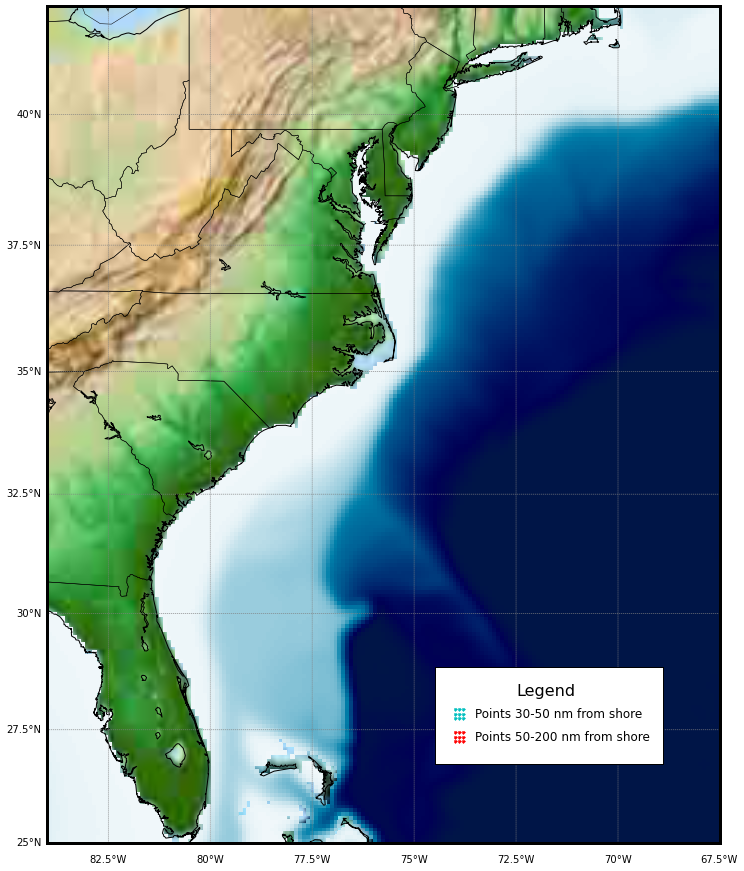

In [16]:
#-----------------------------------------------------------------------------
# Plot Data using Basemap mercator projection
#-----------------------------------------------------------------------------
print 'Plotting data.'
plt.clf()
fig=plt.figure(num=None, figsize=(15, 15), dpi=300, facecolor='w')
m=Basemap(projection='merc',llcrnrlat=25,urcrnrlat=42,\
          llcrnrlon=-84,urcrnrlon=-67.5,lat_ts=20,resolution='i')

# Add Grid Lines
m.drawparallels(np.arange(0.,90.,2.5), labels=[1,0,0,0],\
                fontsize=10, linewidth=0.75, color='.5')
m.drawmeridians(np.arange(-105.,-35.,2.5), labels=[0,0,0,1],\
                fontsize=10, linewidth=0.75, color='.5')

# Draw a thick border around the whole map
m.drawmapboundary(linewidth=3)

# Plot Data
xi, yi = m(lon,lat)
cs = m.pcolormesh(xi,yi,-h,cmap=cm.ocean,vmin=-7000, vmax=150)

# Contour depths (but first mask Pacific)
h=np.ma.array(h,mask=1.0-hmask)
xi, yi = m(lon,lat)
cn = m.contour(xi,yi,h,[100,500,1000,2000,3000,4000],linewidth=1.5,colors='0.7')

# Add Coastlines, States, and Country Boundaries
m.drawcoastlines()
m.drawstates()
m.drawcountries()
m.etopo()
#m.fillcontinents(color='grey')

#for i in range(0,len(ln)):
xi, yi = m(ln,lt)
#Sk = m.scatter(xi,yi,s=15,c='r',linewidth=None,alpha=1)
m.plot(xi,yi,'r.')

xi, yi = m(ln30,lt30)
m.plot(xi,yi,'c.')

#xi,yi = m([-81,-77],[30.7,30.2])
#m.plot(xi,yi,'k')

# Add Rectangle as base for legend
lns=[-74.5,-68.9,-68.9,-74.5]
lts=[26.75,26.75,28.85,28.85]
x,y = m(lns,lts)
xy = zip(x,y)
poly = Polygon( xy, facecolor='white')
pt= plt.gca().add_patch(poly)
pt.set_zorder(3)

# Add Cyan Points to legend
dy=0.08123
dx=0.097285
xi,yi = m([-74,-74+dx,-74+dx+dx,-74,-74+dx,-74+dx+dx,-74,-74+dx,-74+dx+dx],[27.75,27.75,27.75,27.75+dx,27.75+dx,27.75+dx,27.75+dx+dx,27.75+dx+dx,27.75+dx+dx])
zx=m.plot(xi,yi,'c.',zorder=3)

xi,yi = m(-73.5,27.85)
plt.text(xi,yi,'Points 30-50 nm from shore',fontsize=12,ha='left',va='center',color='k')

xi,yi = m([-74,-74+dx,-74+dx+dx,-74,-74+dx,-74+dx+dx,-74,-74+dx,-74+dx+dx],[27.25,27.25,27.25,27.25+dx,27.25+dx,27.25+dx,27.25+dx+dx,27.25+dx+dx,27.25+dx+dx])
zx=m.plot(xi,yi,'r.',zorder=3)

xi,yi = m(-73.5,27.35)
plt.text(xi,yi,'Points 50-200 nm from shore',fontsize=12,ha='left',va='center',color='k')

xi,yi = m(-72.45,28.35)
plt.text(xi,yi,'Legend',fontsize=16,ha='left',va='center',color='k')

# Add Title
#plt.title('Particle Seeding Locations')


In [ ]:
# Close the input file
input_data.close()

In [17]:
ln30

array([], dtype=float64)

In [332]:
len(ln)*365.25*8

13394448.0

In [331]:
len(ln)/16*365.25*8

835692.0

In [330]:
f01=open('particle_file_01.csv','w')
f02=open('particle_file_02.csv','w')
f03=open('particle_file_03.csv','w')
f04=open('particle_file_04.csv','w')
f05=open('particle_file_05.csv','w')
f06=open('particle_file_06.csv','w')
f07=open('particle_file_07.csv','w')
f08=open('particle_file_08.csv','w')
f09=open('particle_file_09.csv','w')
f10=open('particle_file_10.csv','w')
f11=open('particle_file_11.csv','w')
f12=open('particle_file_12.csv','w')
f13=open('particle_file_13.csv','w')
f14=open('particle_file_14.csv','w')
f15=open('particle_file_15.csv','w')
f16=open('particle_file_16.csv','w')
for i in range(0,int(365.25*8)):
    for j in range(0,len(ln)):
        ttt='%8.5f %9.5f -0.50 %i\n' % (lt[j],ln[j],int(i*86400/8.0))
        part_block=j/(len(ln)/16.0)
        if (part_block < 1):
            f01.write(ttt)
        elif (part_block < 2):
            f02.write(ttt)
        elif (part_block < 3):
            f03.write(ttt)
        elif (part_block < 4):
            f04.write(ttt)
        elif (part_block < 5):
            f05.write(ttt)
        elif (part_block < 6):
            f06.write(ttt)
        elif (part_block < 7):
            f07.write(ttt)
        elif (part_block < 8):
            f08.write(ttt)
        elif (part_block < 9):
            f09.write(ttt)
        elif (part_block < 10):
            f10.write(ttt)
        elif (part_block < 11):
            f11.write(ttt)
        elif (part_block < 12):
            f12.write(ttt)
        elif (part_block < 13):
            f13.write(ttt)
        elif (part_block < 14):
            f14.write(ttt)
        elif (part_block < 15):
            f15.write(ttt)
        else:
            f16.write(ttt)
                   
f01.close()
f02.close()
f03.close()
f04.close()
f05.close()
f06.close()
f07.close()
f08.close()
f09.close()
f10.close()
f11.close()
f12.close()
f13.close()
f14.close()
f15.close()
f16.close()
                   